# Choosing the number of replications

The **confidence interval method** can be used to select the number of replications to run. The more replications you run, the narrower your confidence interval becomes, leading to a more precise estimate of the model's mean performance.

First, you select a desired confidence interval - for example, 95%. Then, run the model with an increasing number of replications, and identify the number required to achieve that precision in the estimate of a given metric - and also, to maintain that precision (as the intervals may converge or expand again later on).

This method is less useful for values very close to zero - so, for example, when using utilisation (which ranges from 0 to 1) it is recommended to multiple values by 100.

When selecting the number of replications you should repeat the analysis for all performance measures and select the highest value as your number of replications.

This notebook shares two ways of implementing this: **manually** and **automated**.

At the end, there is a section that walks **step-by-step through the classes and algorithm used for the automated versions**.

Credit:

* Code for this notebooks was adapted from:
    * Tom Monks (2025) [HPDM097 - Making a difference with health data](https://github.com/health-data-science-OR/stochastic_systems) (MIT Licence).
    * Tom Monks (2025) [sim-tools: tools to support the Discrete-Event Simulation process in python](https://github.com/TomMonks/sim-tools) (MIT Licence).

## Set-up

Load required packages.

In [1]:
# pylint: disable=missing-module-docstring
# To ensure any updates to `simulation/` are fetched without needing to restart
# the notebook environment, reload `simulation/` before execution of each cell
%load_ext autoreload
%autoreload 1
%aimport simulation

In [2]:
# pylint: disable=wrong-import-position
import os
import time

from IPython.display import display
import plotly.io as pio

from simulation.model import Param, Runner
from simulation.replications import (
    ReplicationsAlgorithm, confidence_interval_method_simple,
    confidence_interval_method, plotly_confidence_interval_method)

Display plotly express figures as non-interactive figures. This means they will be visible when browsing the notebooks on GitHub. To switch these back to interactive figures, simply remove this line.

In [3]:
pio.renderers.default = 'svg'

Start timer.

In [4]:
notebook_start_time = time.time()

Define path to outputs folder

In [5]:
# pylint: disable=duplicate-code
OUTPUT_DIR = '../outputs/'

Define labels for variables in the dataset, and metrics to use in assessments.

In [6]:
LABELS = {
    'arrivals': 'Patient arrivals (n)',
    'mean_q_time_nurse': 'Mean wait time for nurse (minutes)',
    'mean_n_consult_time': 'Mean consultation time with nurse (minutes)',
    'mean_time_with_nurse': 'Mean consultation time with nurse (minutes)',
    'mean_nurse_utilisation': 'Mean nurse utilisation',
    'adj_mean_nurse_utilisation': 'Mean nurse utilisation (*100 - %)',
    'adj_mean_q_time_nurse': 'Mean wait time for nurse (*100) (minutes)',
    'mean_nurse_utilisation_tw': 'Time-weighted mean nurse utilisation',
    'mean_nurse_q_length': 'Time-weighted mean queue length for nurse (n)',
    'patient_inter': 'Patient inter-arrival time',
    'number_of_nurses': 'Number of nurses',
    'utilisation': 'Utilisation',
    'running_mean_wait_time': 'Running mean nurse wait time (minutes)'
}

METRICS = [
    'mean_time_with_nurse', 'mean_q_time_nurse', 'mean_nurse_utilisation']

## Manual inspection

First, we demonstrate how to do this manually, by inspecting the output table and figures to determine an appropriate number of replications.

We provide two functions to do this - `confidence_interval_method_simple` and `confidence_interval_method` - both will provide the same results, they just use different methods for calculating the statistics.

### `confidence_interval_method_simple`

In [7]:
solutions, cumulative = confidence_interval_method_simple(
    replications=40,
    metrics=METRICS,
    desired_precision=0.05,
    verbose=True
)

display(cumulative.head())
display(cumulative.tail())

mean_time_with_nurse: Reached desired precision in 6 replications.
mean_q_time_nurse: Reached desired precision in 31 replications.
mean_nurse_utilisation: Reached desired precision in 6 replications.


,replications,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation,metric
0,1,9.842380,9.842380,NaN,NaN,NaN,NaN,mean_time_with_nurse
1,2,10.060424,9.951402,NaN,NaN,NaN,NaN,mean_time_with_nurse
2,3,9.925090,9.942631,0.110075,9.669189,10.216073,0.027502,mean_time_with_nurse
3,4,9.938504,9.941599,0.089900,9.798549,10.084650,0.014389,mean_time_with_nurse
4,5,10.016611,9.956602,0.084775,9.851339,10.061864,0.010572,mean_time_with_nurse


,replications,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation,metric
35,36,0.492981,0.497883,0.007143,0.495466,0.500300,0.004854,mean_nurse_utilisation
36,37,0.508118,0.498159,0.007242,0.495745,0.500574,0.004847,mean_nurse_utilisation
37,38,0.502153,0.498264,0.007172,0.495907,0.500622,0.004731,mean_nurse_utilisation
38,39,0.499857,0.498305,0.007082,0.496010,0.500601,0.004607,mean_nurse_utilisation
39,40,0.512021,0.498648,0.007319,0.496307,0.500989,0.004694,mean_nurse_utilisation


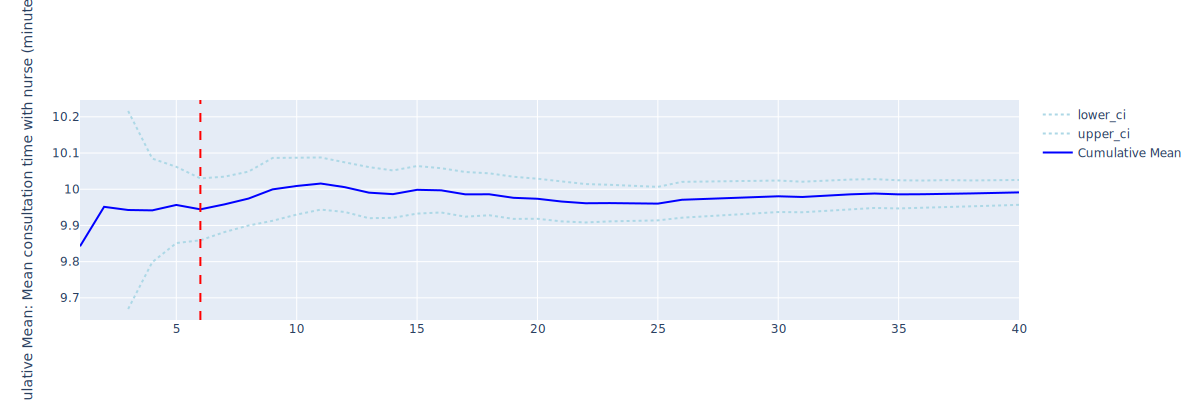

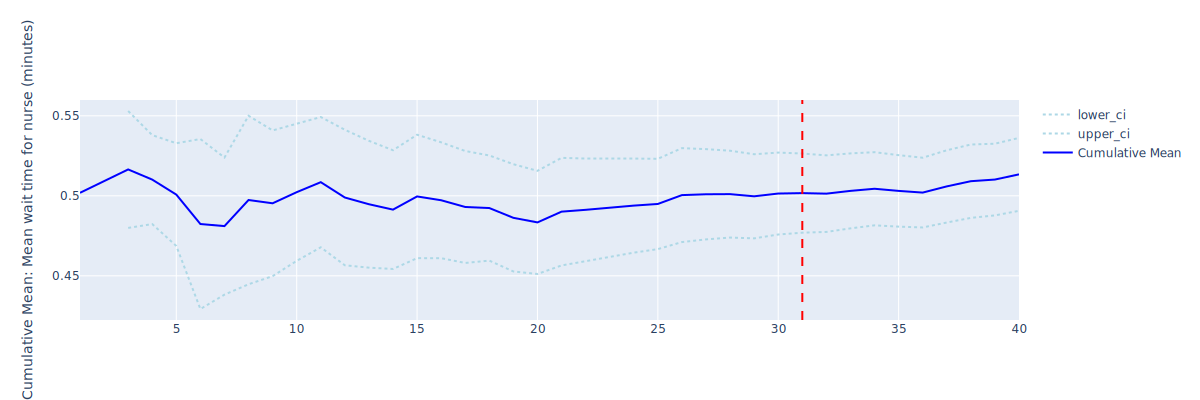

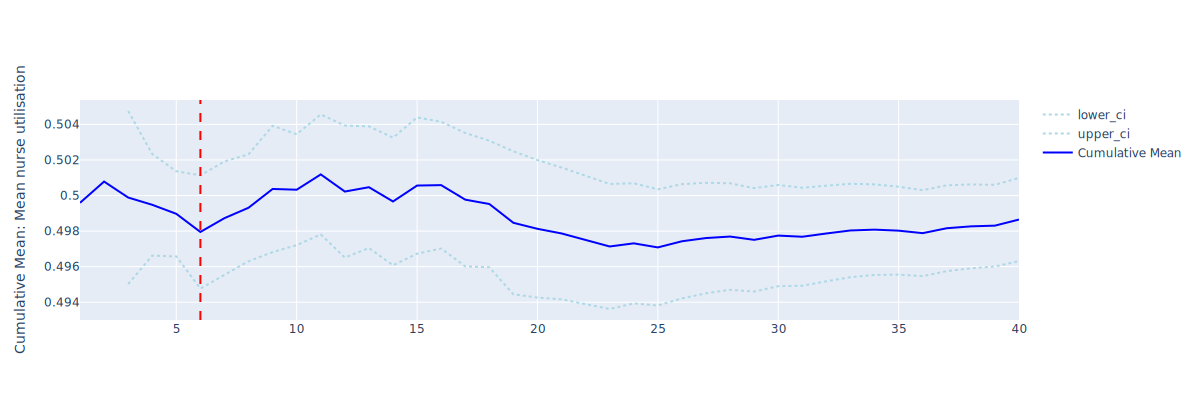

In [8]:
for metric in METRICS:
    p = plotly_confidence_interval_method(
        n_reps=solutions[metric],
        conf_ints=cumulative[cumulative['metric'] == metric],
        metric_name=LABELS[metric],
        file_path=os.path.join(OUTPUT_DIR, f'choose_reps_{metric}.png'))
    p.show()

### `confidence_interval_method`

In [9]:
solutions, cumulative = confidence_interval_method(
    replications=40,
    metrics=METRICS,
    desired_precision=0.05,
    verbose=True
)

display(cumulative.head())
display(cumulative.tail())

mean_time_with_nurse: Reached desired precision in 5 replications.
mean_q_time_nurse: Reached desired precision in 30 replications.
mean_nurse_utilisation: Reached desired precision in 5 replications.


,replications,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation,metric
0,1,9.842380,9.842380,NaN,NaN,NaN,NaN,mean_time_with_nurse
1,2,10.060424,9.951402,NaN,NaN,NaN,NaN,mean_time_with_nurse
2,3,9.925090,9.942631,0.110075,9.669189,10.216073,0.027502,mean_time_with_nurse
3,4,9.938504,9.941599,0.089900,9.798549,10.084650,0.014389,mean_time_with_nurse
4,5,10.016611,9.956602,0.084775,9.851339,10.061864,0.010572,mean_time_with_nurse


,replications,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation,metric
35,36,0.492981,0.497883,0.007143,0.495466,0.500300,0.004854,mean_nurse_utilisation
36,37,0.508118,0.498159,0.007242,0.495745,0.500574,0.004847,mean_nurse_utilisation
37,38,0.502153,0.498264,0.007172,0.495907,0.500622,0.004731,mean_nurse_utilisation
38,39,0.499857,0.498305,0.007082,0.496010,0.500601,0.004607,mean_nurse_utilisation
39,40,0.512021,0.498648,0.007319,0.496307,0.500989,0.004694,mean_nurse_utilisation


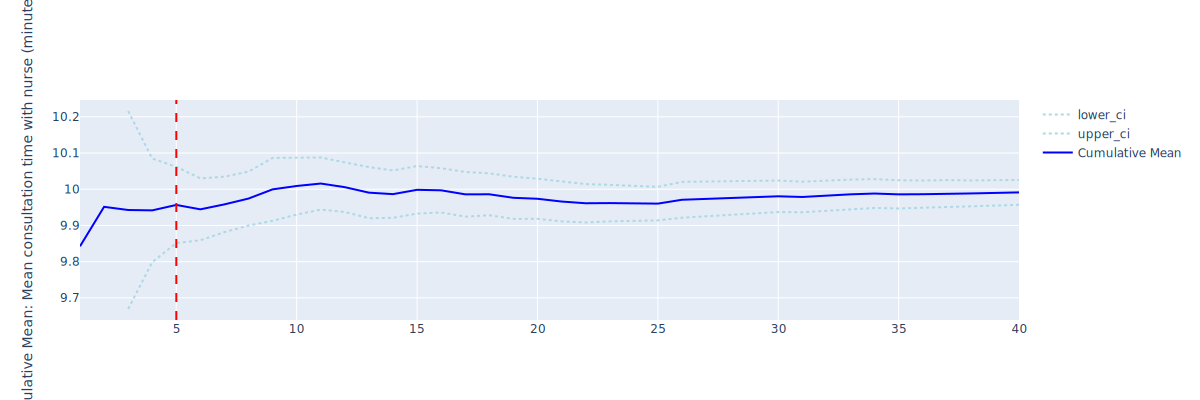

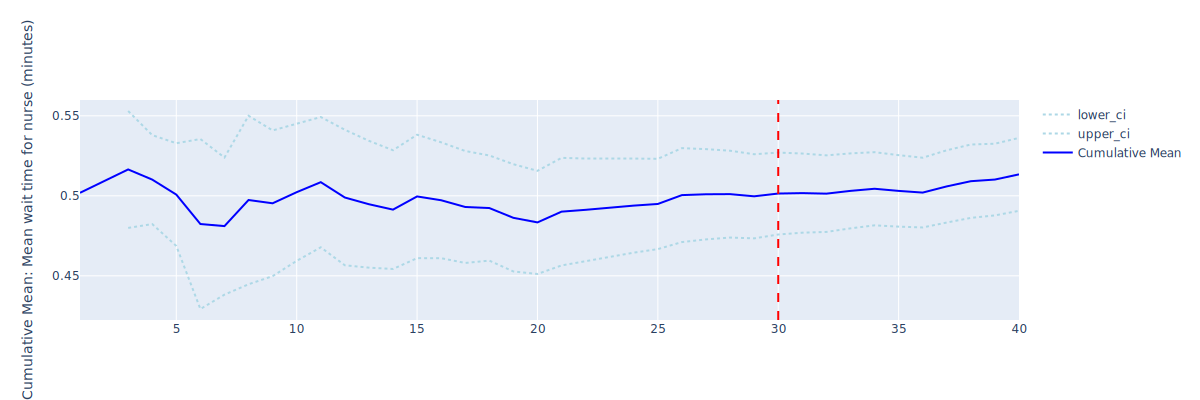

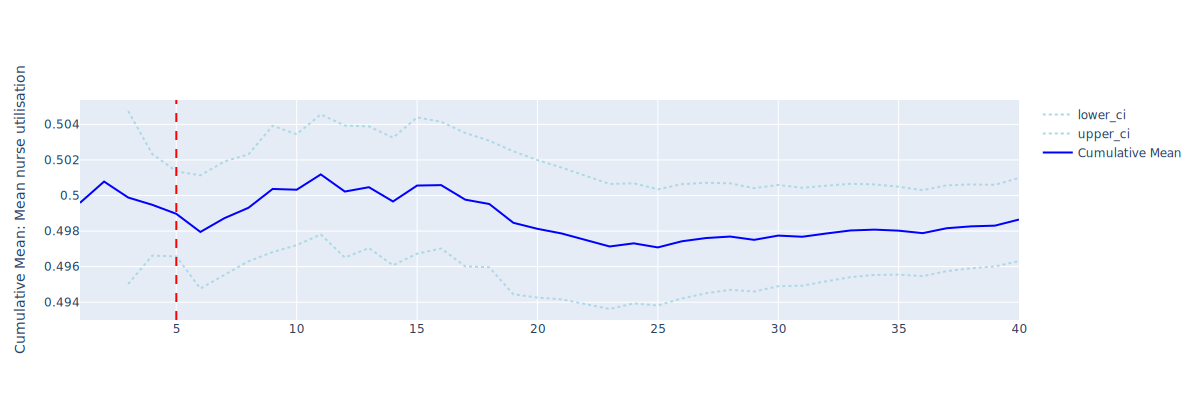

In [10]:
for metric in METRICS:
    p = plotly_confidence_interval_method(
        n_reps=solutions[metric],
        conf_ints=cumulative[cumulative['metric'] == metric],
        metric_name=LABELS[metric])
    p.show()

## Automated detection of appropriate number of replications

Run the algorithm (which will run model with increasing reps) for a few different metrics.

In [11]:
# Set up and run the algorithm
analyser = ReplicationsAlgorithm()
solutions, cumulative = analyser.select(runner=Runner(Param()),
                                        metrics=METRICS)

# View results
display(solutions)
display(cumulative)

{'mean_time_with_nurse': 3,
 'mean_q_time_nurse': 31,
 'mean_nurse_utilisation': 3}

,replications,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation,metric
0,1,9.842380,9.842380,NaN,NaN,NaN,NaN,mean_time_with_nurse
1,2,10.060424,9.951402,NaN,NaN,NaN,NaN,mean_time_with_nurse
2,3,9.925090,9.942631,0.110075,9.669189,10.216073,0.027502,mean_time_with_nurse
3,4,9.938504,9.941599,0.089900,9.798549,10.084650,0.014389,mean_time_with_nurse
4,5,10.016611,9.956602,0.084775,9.851339,10.061864,0.010572,mean_time_with_nurse
5,6,9.883801,9.944468,0.081442,9.859000,10.029936,0.008595,mean_time_with_nurse
6,7,10.040555,9.958195,0.082742,9.881671,10.034719,0.007685,mean_time_with_nurse
7,8,10.086612,9.974247,0.089048,9.899801,10.048693,0.007464,mean_time_with_nurse
0,1,0.501873,0.501873,NaN,NaN,NaN,NaN,mean_q_time_nurse
1,2,0.516264,0.509069,NaN,NaN,NaN,NaN,mean_q_time_nurse


Create plots

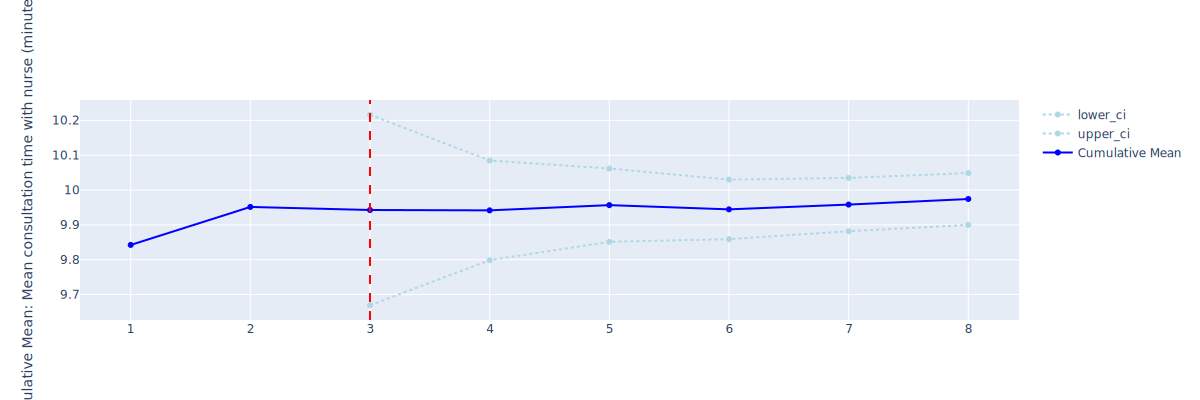

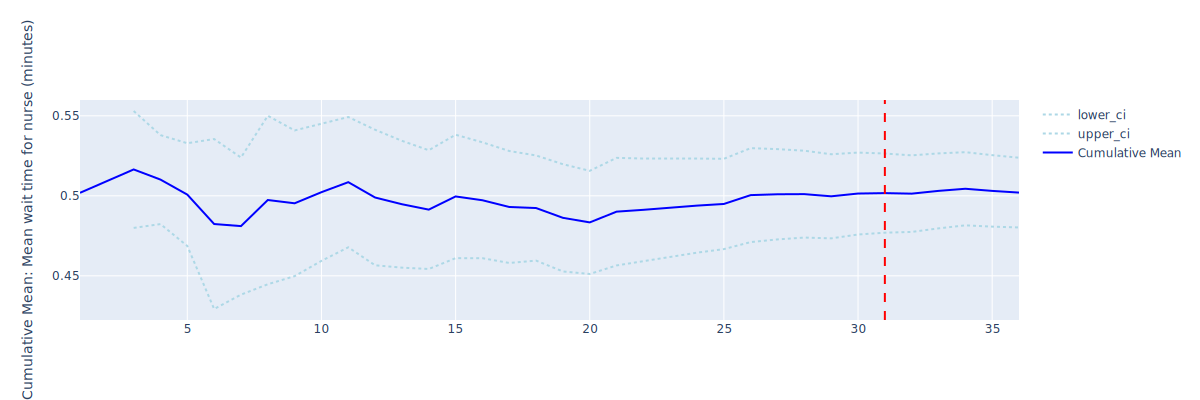

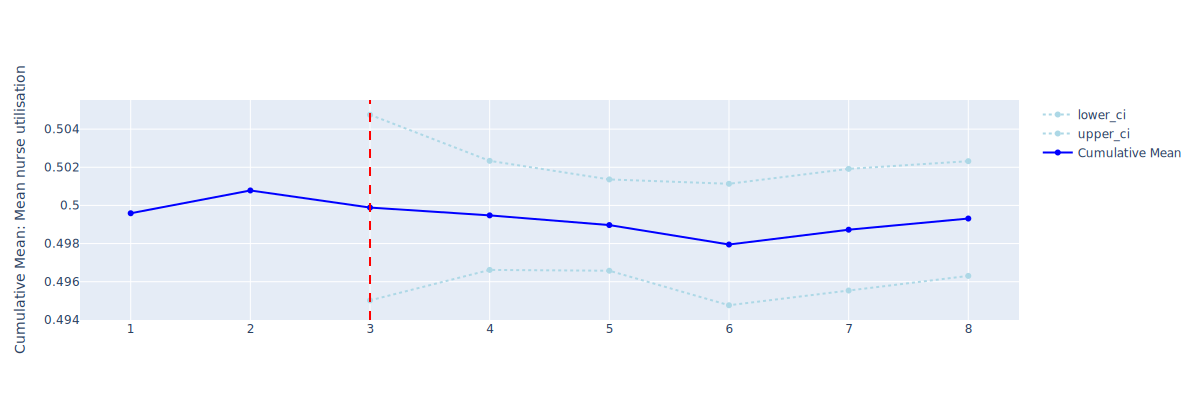

In [12]:
for metric in METRICS:
    p = plotly_confidence_interval_method(
        n_reps = solutions[metric],
        conf_ints = cumulative[cumulative['metric'] == metric],
        metric_name=LABELS[metric])
    p.show()

## Explanation of the automated method

This section walks through how the automation code is structured. The algorithm that determines the number of replications is `ReplicationsAlgorithm`. This depends on other classes including `OnlineStatistics` and `ReplicationTabulizer`.

### OnlineStatistics

`OnlineStatistics` is designed to:

* Keep a **running mean and variance**.
* Return **other statistics** based on these (e.g. standard deviation, confidence intervals).
* **Call the `update()`** method of `ReplicationTabulizer` whenever a new data point is processed by `OnlineStatistics.

More information...

<details>
  <summary><b>How do the running mean and variance calculations work?</b></summary>

The running mean and variance are updated iteratively with each new data point provided, **without requiring the storage of all previous data points**. This approach is called "online" because we only need to store a small set of values (such as the current mean and variance), rather than maintaining an entire list of past values.

For example, focusing on the mean, normally you would need to store all the data points in a list and sum them up to compute the average - for example:

```
data_points = [1, 2, 3, 4, 5]
mean = sum(data_points) / len(data_points)
```

This works fine for small datasets, but as the data grows, maintaining the entire list becomes impractical. Instead, we can update the mean without storing the previous data points using **Welford's algorithm**. The formula for the running mean is:

$$
\mu_n = \mu_{n-1} + \frac{x_n - \mu_{n-1}}{n}
$$

Where:

- $\mu_n$ is the running mean after the $n$-th data point.
- $x_n$ is the new data point.
- $\mu_{n-1}$ is the running mean before the new data point.

The key thing to notice here is that, to update the mean, **all we needed to know was the current running mean, the new data point, and the number of data points**. A similar formula exists for calculating variance.

In our code, every time we call `update()` with a new data point, the mean and variance are adjusted, with `n` keeping track of the number of data points so far.

```
class OnlineStatistics:
    def __init__(self):
        self.mean = 0
        self.n = 0

    def update(self, new_data_point):
        self.n += 1
        self.mean += (new_data_point - self.mean) / self.n
```
</details>

<br>

<details>
  <summary><b>What other statistics can it calculate?</b></summary>
  
`OnlineStatistics` then has a series of methods which can return other statistics based on the current mean, variance, and count:

* Variance
* Standard deviation
* Standard error
* Half width of the confidence interval
* Lower confidence interval bound
* Upper confidence interval bound
* Deviation of confidence interval from the mean

These are each marked with `@property`. This is a stylist choice, that simply means, we are able to get the value by running e.g. `stats.lci`, instead of `stats.lci()`.
</details>

### ReplicationTabulizer

`ReplicationTabulizer` keeps track of our results. It:

* Stores **lists with various statistics**, which are updated whenever `update()` is called.
* Can convert these into a **dataframe** using the `summary_frame()` method.

![Interaction between OnlineStatistics and ReplicationTabulizer](../images/replications_statistics.png)

### ReplicationsAlgorithm

<mark>TODO</mark>

## Run time

In [13]:
# Get run time in seconds
notebook_end_time = time.time()
runtime = round(notebook_end_time - notebook_start_time)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime // 60}m {runtime % 60}s')

Notebook run time: 0m 10s
